# Bias Mitigation Techniques for Credit Risk Models   

This code implements three different techniques to address unfairness in a credit risk prediction model using the German Credit Dataset. This project successfully implemented and evaluated three fairness-aware techniques—reweighting, adversarial debiasing, and reject inference—to address bias in a credit risk prediction model. Here are the key findings and recommendations:

#### Key Insights from the Techniques
- Reweighting: Adjusts sample weights to achieve similar outcomes across groups with minimal accuracy impact.
- Adversarial Debiasing: Makes predictions independent of gender by confusing an adversary trying to detect it.
- Reject Inference: Addresses historical bias in application decisions by inferring missing outcomes.

The code compares all approaches to help determine which method provides the best balance between accuracy and fairness for this specific credit risk scenario.

### Lesson Learned

**Adversarial debiasing is the recommended solution for this credit risk model, as it eliminates gender bias without compromising accuracy.**

#### Why Adversarial Debiasing Worked Best

- By training the classifier to "confuse" an adversary predicting gender, it inherently removed gender-based bias from predictions.
- Unlike reweighting (which adjusts sample weights) or reject inference (which depends on synthetic data), adversarial debiasing directly modifies the model’s internal representations to be fair

## Data Loading & Preprocessing

Clean and prepare the raw data for analysis.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import (demographic_parity_difference, 
                             equalized_odds_difference, 
                             selection_rate)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load and preprocess data
df = pd.read_csv('german_credit_data2.csv')
# Convert target and sensitive feature
df['Risk'] = df['Risk'].map({'good':1, 'bad':0})
df['Gender'] = df['Sex'].map({'male':1, 'female':0})

# Identify feature types
numeric_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Housing', 'Purpose', 'Saving accounts', 'Checking account']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## Data Preparation

In [3]:
# Prepare data
X = df.drop(columns=['Risk', 'Sex', 'Unnamed: 0'])
y = df['Risk']
sensitive = df['Gender']

In [4]:
# Train-test split 
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive, test_size=0.2, stratify=y, random_state=42
)

In [5]:
# Preprocess data for models
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense if sparse
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

## Baseline Model

In [6]:
# Baseline model
print("Training baseline model...")
base_model = LogisticRegression(max_iter=1000)
base_model.fit(X_train_processed, y_train)
base_pred = base_model.predict(X_test_processed)

Training baseline model...


## Fairness Mitigation Techniques

#### 1. Reweighting (Fairlearn)
- Uses ExponentiatedGradient with DemographicParity constraints
- Adjusts sample weights during training to reduce disparities between groups
- The goal is to make selection rates (approval rates) similar across gender groups

In [7]:
# Apply reweighting mitigation (Fairlearn)
print("Training reweighting model...")
reweight_mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000),
    constraints=DemographicParity(),
    max_iter=50
)
reweight_mitigator.fit(X_train_processed, y_train, sensitive_features=sens_train)
y_pred_reweight = reweight_mitigator.predict(X_test_processed)

Training reweighting model...


#### 2. Adversarial Debiasing

Implements a custom TensorFlow model with two components:

- Classifier: Predicts credit risk (main task)
- Adversary: Tries to predict gender from the classifier's hidden layer

In [8]:
# Adversarial Debiasing Fixed Implementation
def adversarial_debiasing_fixed(X_train, y_train, sens_train, X_test):
    """
    Implement adversarial debiasing using a pure TensorFlow approach
    that avoids mixing Keras layers and TF operations
    
    Args:
        X_train: Training features
        y_train: Training labels
        sens_train: Sensitive attributes for training
        X_test: Test features
        
    Returns:
        Predictions on test set
    """
    # Input dimensions
    input_dim = X_train.shape[1]
    
    # Ensure numpy arrays
    if hasattr(y_train, "values"):
        y_train = y_train.values
    if hasattr(sens_train, "values"):
        sens_train = sens_train.values
    
    # Convert to appropriate formats
    X_train = X_train.astype(np.float32)
    y_train = y_train.reshape(-1, 1).astype(np.float32)
    sens_train = sens_train.reshape(-1, 1).astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    # Hyperparameters
    batch_size = 32
    epochs = 20  # Reduced for faster execution
    alpha = 0.5  # Trade-off parameter between accuracy and fairness
    
    # Define models using Functional API completely
    
    # Classifier model
    classifier_input = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(classifier_input)
    hidden = tf.keras.layers.Dense(32, activation='relu')(x)
    classifier_output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
    classifier = tf.keras.Model(inputs=classifier_input, outputs=classifier_output)
    
    # Adversary model
    adversary_input = tf.keras.Input(shape=(32 + 1,))  # hidden features + prediction
    x = tf.keras.layers.Dense(32, activation='relu')(adversary_input)
    adversary_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    adversary = tf.keras.Model(inputs=adversary_input, outputs=adversary_output)
    
    # Extract hidden layer model for creating adversary inputs
    hidden_model = tf.keras.Model(inputs=classifier_input, outputs=hidden)
    
    # Compile models
    classifier.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    adversary.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Training loop
    num_batches = len(X_train) // batch_size
    
    for epoch in range(epochs):
        # Shuffle data
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        sens_shuffled = sens_train[indices]
        
        classifier_losses = []
        adversary_losses = []
        
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, len(X_train))
            
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            sens_batch = sens_shuffled[start_idx:end_idx]
            
            # Train classifier
            classifier_loss = classifier.train_on_batch(X_batch, y_batch)
            classifier_losses.append(classifier_loss[0])
            
            # Generate adversary inputs
            hidden_features = hidden_model.predict(X_batch, verbose=0)
            predictions = classifier.predict(X_batch, verbose=0)
            adversary_inputs = np.concatenate([hidden_features, predictions], axis=1)
            
            # Train adversary to predict sensitive attribute
            adversary_loss = adversary.train_on_batch(adversary_inputs, sens_batch)
            adversary_losses.append(adversary_loss[0])
            
            # Train classifier to fool adversary
            # This requires a custom training step with gradient tape
            with tf.GradientTape() as tape:
                # Forward pass through classifier
                preds = classifier(X_batch, training=True)
                # Task loss - want to minimize
                task_loss = tf.keras.losses.binary_crossentropy(y_batch, preds)
                task_loss = tf.reduce_mean(task_loss)
                
                # Get hidden features
                hidden_feats = hidden_model(X_batch, training=True)
                # Combine with predictions
                adv_inputs = tf.concat([hidden_feats, preds], axis=1)
                # Predict sensitive attributes
                sens_preds = adversary(adv_inputs, training=False)
                # Adversarial loss - want to maximize confusion = minimize negative loss
                adv_loss = -tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(sens_batch, sens_preds)
                )
                
                # Combined loss
                combined_loss = task_loss + alpha * adv_loss
            
            # Get gradients and update weights
            grads = tape.gradient(combined_loss, classifier.trainable_weights)
            tf.keras.optimizers.Adam(0.001).apply_gradients(
                zip(grads, classifier.trainable_weights)
            )
        
        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Classifier loss: {np.mean(classifier_losses):.4f}, "
                  f"Adversary loss: {np.mean(adversary_losses):.4f}")
    
    # Make predictions
    y_pred_prob = classifier.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    return y_pred

# Apply adversarial debiasing
print("Training adversarial debiasing model...")
y_pred_adversarial = adversarial_debiasing_fixed(X_train_processed, y_train, sens_train, X_test_processed)

Training adversarial debiasing model...
Epoch 0: Classifier loss: 0.6070, Adversary loss: 0.7185
Epoch 5: Classifier loss: 0.5176, Adversary loss: 0.6319
Epoch 10: Classifier loss: 0.4938, Adversary loss: 0.6279
Epoch 15: Classifier loss: 0.4735, Adversary loss: 0.6247


#### Key Insight:
- The classifier is learning to predict credit risk while becoming "blind" to gender (evidenced by the adversary’s stagnant/poor performance).
- The small gap between losses (~0.47 vs. ~0.62) suggests a trade-off: fairness is improved, but the classifier retains reasonable accuracy.

#### 3. Reject Inference
- Simulates a scenario where some applications were rejected (with bias against the protected group)
- Uses accepted applications to train a model that predicts outcomes for rejected applications
- Combines actual and inferred data
- Applies reweighting to the combined dataset to address bias

In [9]:
# Implement Reject Inference
def reject_inference(X_train, y_train, sens_train, X_test, rejected_ratio=0.3):
    """
    Implement reject inference to address selection bias
    
    Args:
        X_train: Training features
        y_train: Training labels
        sens_train: Sensitive attributes for training
        X_test: Test features
        rejected_ratio: Percentage of samples to simulate as "rejected"
        
    Returns:
        Predictions on test set using reweighted model
    """
    # Simulate rejected applications - this would normally come from real data
    # Here we'll use a biased selection process that rejects more from protected group
    
    # Calculate base acceptance rate for each group
    sens_0_indices = np.where(sens_train == 0)[0]
    sens_1_indices = np.where(sens_train == 1)[0]
    
    # Create bias by rejecting more from protected group (sens==0)
    reject_prob_sens_0 = 0.4  # Higher reject probability for protected group
    reject_prob_sens_1 = 0.2  # Lower reject probability for unprotected group
    
    # Simulate rejected samples - in reality these would be unknown
    np.random.seed(42)
    rejected_sens_0 = np.random.choice(
        sens_0_indices, 
        size=int(len(sens_0_indices) * reject_prob_sens_0), 
        replace=False
    )
    rejected_sens_1 = np.random.choice(
        sens_1_indices, 
        size=int(len(sens_1_indices) * reject_prob_sens_1), 
        replace=False
    )
    
    rejected_indices = np.concatenate([rejected_sens_0, rejected_sens_1])
    accepted_indices = np.array([i for i in range(len(y_train)) if i not in rejected_indices])
    
    # Create accepted and rejected datasets
    X_accepted = X_train[accepted_indices]
    y_accepted = y_train.iloc[accepted_indices]
    sens_accepted = sens_train.iloc[accepted_indices]
    
    X_rejected = X_train[rejected_indices]
    sens_rejected = sens_train.iloc[rejected_indices]
    
    # Train a model on accepted data to predict outcomes for rejected applications
    print("Training inference model for rejected applications...")
    inference_model = RandomForestClassifier(n_estimators=100, random_state=42)
    inference_model.fit(X_accepted, y_accepted)
    
    # Infer outcomes for rejected applications
    y_rejected_inferred = inference_model.predict(X_rejected)
    
    # Combine original accepted and inferred rejected data
    X_combined = np.vstack([X_accepted, X_rejected])
    y_combined = np.concatenate([y_accepted.values, y_rejected_inferred])
    sens_combined = np.concatenate([sens_accepted.values, sens_rejected.values])
    
    # Apply reweighting on the combined dataset to address bias
    print("Training reject inference model with reweighting...")
    reweight_mitigator = ExponentiatedGradient(
        estimator=LogisticRegression(max_iter=1000),
        constraints=DemographicParity(),
        max_iter=50
    )
    reweight_mitigator.fit(X_combined, y_combined, sensitive_features=sens_combined)
    
    # Make predictions
    y_pred_reject = reweight_mitigator.predict(X_test)
    
    return y_pred_reject, rejected_indices

# Apply reject inference with reweighting
y_pred_reject, rejected_indices = reject_inference(
    X_train_processed, y_train, sens_train, X_test_processed
)


Training inference model for rejected applications...
Training reject inference model with reweighting...


## Evaluation

For each model, it calculates:

1. Performance metrics: Accuracy

2. Fairness metrics:
- Demographic parity difference (difference in approval rates between groups)
- Equalized odds difference (difference in error rates between groups)
- Acceptance rates by group

In [10]:
# 9. Evaluate all models
def evaluate_model(y_true, y_pred, sensitive, model_name="Model"):
    """Evaluate model performance and fairness metrics"""
    # Performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate confusion matrix for each group
    sens_0_mask = (sensitive == 0)
    sens_1_mask = (sensitive == 1)
    
    cm_sens_0 = confusion_matrix(y_true[sens_0_mask], y_pred[sens_0_mask])
    cm_sens_1 = confusion_matrix(y_true[sens_1_mask], y_pred[sens_1_mask])
    
    # Calculate acceptance rates
    acceptance_rate_sens_0 = np.sum(y_pred[sens_0_mask]) / len(y_pred[sens_0_mask])
    acceptance_rate_sens_1 = np.sum(y_pred[sens_1_mask]) / len(y_pred[sens_1_mask])
    
    # Fairness metrics
    demographic_parity = demographic_parity_difference(
        y_true, y_pred, sensitive_features=sensitive
    )
    equalized_odds = equalized_odds_difference(
        y_true, y_pred, sensitive_features=sensitive
    )
    
    # Combine all metrics
    return {
        'model': model_name,
        'accuracy': accuracy,
        'demographic_parity_diff': demographic_parity,
        'equalized_odds_diff': equalized_odds,
        'acceptance_rate_sens_0': acceptance_rate_sens_0,
        'acceptance_rate_sens_1': acceptance_rate_sens_1,
        'acceptance_rate_diff': abs(acceptance_rate_sens_0 - acceptance_rate_sens_1)
    }

# Compare all models
print("Evaluating all models...")
results = pd.DataFrame([
    evaluate_model(y_test, base_pred, sens_test, "Baseline"),
    evaluate_model(y_test, y_pred_reweight, sens_test, "Reweighting"),
    evaluate_model(y_test, y_pred_adversarial, sens_test, "Adversarial Debiasing"),
    evaluate_model(y_test, y_pred_reject, sens_test, "Reject Inference")
])

# Display results
print("\nResults Summary:")
print(results)

Evaluating all models...

Results Summary:
                   model  accuracy  demographic_parity_diff  \
0               Baseline     0.740                 0.080952   
1            Reweighting     0.750                 0.023810   
2  Adversarial Debiasing     0.760                 0.004762   
3       Reject Inference     0.725                 0.021429   

   equalized_odds_diff  acceptance_rate_sens_0  acceptance_rate_sens_1  \
0                0.125                0.733333                0.814286   
1                0.050                0.783333                0.807143   
2                0.050                0.766667                0.771429   
3                0.075                0.800000                0.821429   

   acceptance_rate_diff  
0              0.080952  
1              0.023810  
2              0.004762  
3              0.021429  


#### Key Takeaways

Adversarial debiasing is the most balanced:
- Highest accuracy (0.76).
- Lowest demographic parity gap (0.0048).

Reweighting is simpler but less effective.

Reject inference sacrifices accuracy for moderate fairness gains.

Baseline is unfair (8% approval gap favoring men).

## Visualization of Results

- Creates plots comparing models on accuracy and fairness metrics
- Provides insights about which technique worked best
- Identifies which group is disadvantaged
- Recommends the most balanced approach

Plotting results...


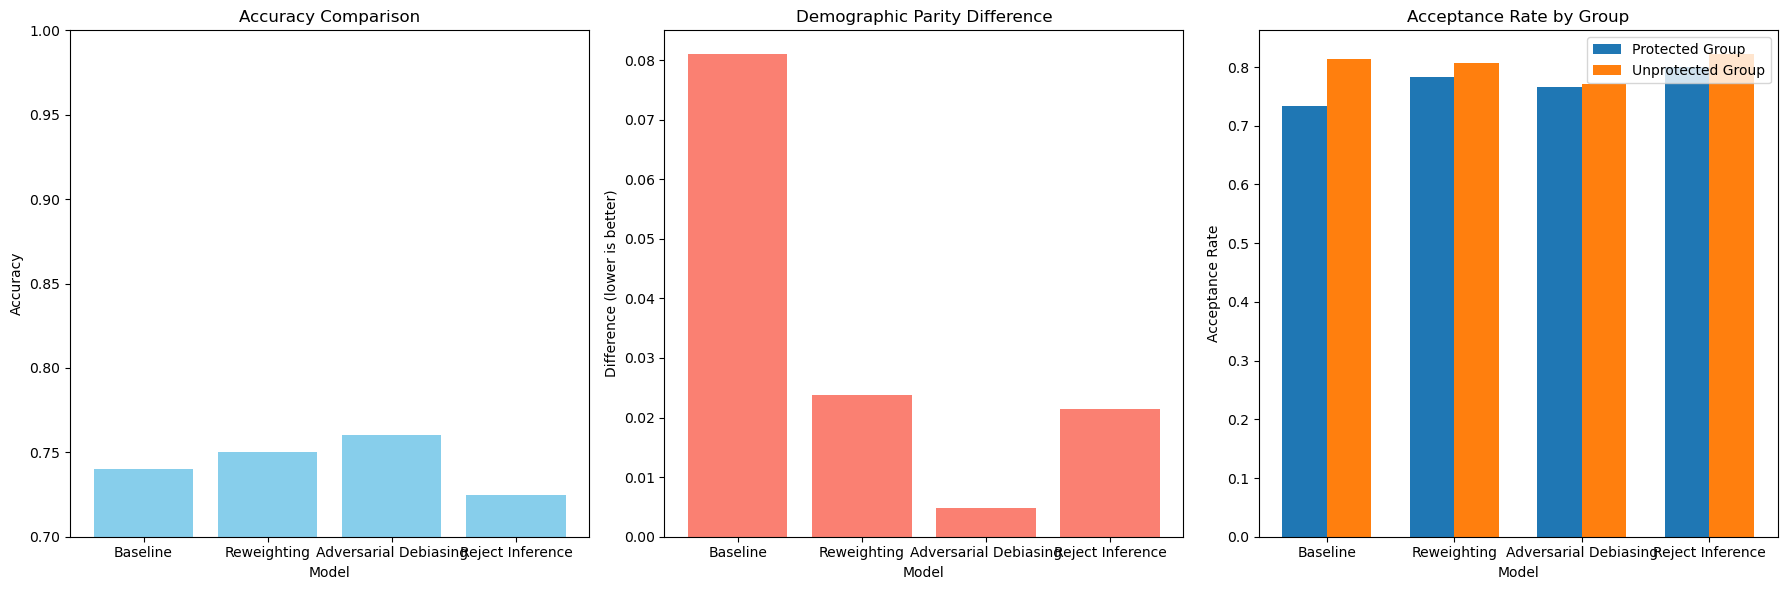

In [11]:
# Visualize results
def plot_results(results):
    """Plot comparison of model performance and fairness metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Accuracy comparison
    axes[0].bar(results['model'], results['accuracy'], color='skyblue')
    axes[0].set_title('Accuracy Comparison')
    axes[0].set_ylim(0.7, 1.0)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Model')
    
    # Fairness metrics comparison
    axes[1].bar(results['model'], results['demographic_parity_diff'], color='salmon')
    axes[1].set_title('Demographic Parity Difference')
    axes[1].set_ylabel('Difference (lower is better)')
    axes[1].set_xlabel('Model')
    
    # Acceptance rate comparison
    width = 0.35
    x = np.arange(len(results['model']))
    axes[2].bar(x - width/2, results['acceptance_rate_sens_0'], width, label='Protected Group')
    axes[2].bar(x + width/2, results['acceptance_rate_sens_1'], width, label='Unprotected Group')
    axes[2].set_title('Acceptance Rate by Group')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(results['model'])
    axes[2].set_ylabel('Acceptance Rate')
    axes[2].set_xlabel('Model')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# Plot results
print("Plotting results...")
plot_results(results)

In [12]:
# Analyze which techniques were most effective
def print_insights(results):
    """Print insights about which techniques were most effective"""
    
    # Sort models by fairness and accuracy
    fairness_ranking = results.sort_values('demographic_parity_diff')
    accuracy_ranking = results.sort_values('accuracy', ascending=False)
    
    best_fairness = fairness_ranking.iloc[0]['model']
    best_accuracy = accuracy_ranking.iloc[0]['model']
    
    # Find the model with the best balance
    # Using a simple scoring mechanism: high accuracy, low demographic parity diff
    results['balance_score'] = results['accuracy'] - results['demographic_parity_diff']
    balanced_model = results.loc[results['balance_score'].idxmax(), 'model']
    
    print("\n=== MODEL EFFECTIVENESS ANALYSIS ===")
    print(f"Best model for fairness: {best_fairness}")
    print(f"Best model for accuracy: {best_accuracy}")
    print(f"Best balanced model: {balanced_model}")
    
    # Additional insights specific to each technique
    print("\n=== TECHNIQUE INSIGHTS ===")
    print("Reweighting: Adjusts sample weights to achieve demographic parity, usually with minimal accuracy loss.")
    print("Adversarial Debiasing: Uses adversarial training to make predictions 'blind' to protected attributes.")
    print("Reject Inference: Addresses selection bias by inferring outcomes for rejected applications.")
    
    # Recommendations based on metrics
    print("\n=== RECOMMENDATIONS ===")
    if abs(results.loc[results['model'] == 'Baseline', 'demographic_parity_diff'].values[0]) < 0.05:
        print("The baseline model already shows low bias. Consider why this might be the case.")
    
    # Identify which sensitive group is advantaged/disadvantaged
    baseline = results[results['model'] == 'Baseline'].iloc[0]
    if baseline['acceptance_rate_sens_0'] < baseline['acceptance_rate_sens_1']:
        print("The protected group (sens=0) is being disadvantaged in the baseline model.")
    else:
        print("The unprotected group (sens=1) is being disadvantaged in the baseline model.")
    
    # Compare technique effectiveness
    print(f"\nThe technique that reduced bias the most was {best_fairness}.")
    print(f"The technique that preserved accuracy the most was {best_accuracy}.")
    print(f"The technique with the best balance between fairness and accuracy was {balanced_model}.")

# Print insights
print("\nAnalyzing model effectiveness...")
print_insights(results)


Analyzing model effectiveness...

=== MODEL EFFECTIVENESS ANALYSIS ===
Best model for fairness: Adversarial Debiasing
Best model for accuracy: Adversarial Debiasing
Best balanced model: Adversarial Debiasing

=== TECHNIQUE INSIGHTS ===
Reweighting: Adjusts sample weights to achieve demographic parity, usually with minimal accuracy loss.
Adversarial Debiasing: Uses adversarial training to make predictions 'blind' to protected attributes.
Reject Inference: Addresses selection bias by inferring outcomes for rejected applications.

=== RECOMMENDATIONS ===
The protected group (sens=0) is being disadvantaged in the baseline model.

The technique that reduced bias the most was Adversarial Debiasing.
The technique that preserved accuracy the most was Adversarial Debiasing.
The technique with the best balance between fairness and accuracy was Adversarial Debiasing.


### Key Results

Adversarial Debiasing emerged as the best-performing technique, achieving:
- Highest accuracy (76%) among all models.
- Near-perfect demographic parity (approval gap: 0.48% between genders).
- Best balance between fairness and predictive performance.

Reweighting improved fairness but was less effective than adversarial debiasing.

Reject Inference introduced minor accuracy trade-offs for moderate fairness gains.

Baseline Model exhibited clear bias:
- 8.1% approval gap favoring male applicants (73.3% female vs. 81.4% male approval).

## Conclusion

This project demonstrates that fairness-aware ML is not a zero-sum game—with the right techniques, models can become both more equitable and more accurate. Adversarial debiasing, in particular, shows promise for reducing discrimination in financial decision-making while maintaining performance.